In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
#分块读入数据（5M），总共有40M
#这里有个小问题就是id特征呈现科学计数法，但其实内部存储的是id应有的数值不必担心
"""
此问题为CTR预估，在这个背景下大致分析特征
id:标识符。click：是否被点击。hour：时间14102100格式。C1-C14->C21:虽为数值型但实质是匿名类别型特征在后续探索过程中要予以一定分析。
bannerpos：广告位置。siteid_domain_category:分别为站点id，区域和分类，app特征亦如此。
device特征有稍许差别，有id，ip和model和type,conn_type.分析device在很大程度上是刻画用户的特征
"""
iters = pd.read_csv("train/train.csv",iterator=True)
chunk = iters.get_chunk(500000)
chunk.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157


In [5]:
#无缺失值
chunk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 24 columns):
id                  500000 non-null float64
click               500000 non-null int64
hour                500000 non-null int64
C1                  500000 non-null int64
banner_pos          500000 non-null int64
site_id             500000 non-null object
site_domain         500000 non-null object
site_category       500000 non-null object
app_id              500000 non-null object
app_domain          500000 non-null object
app_category        500000 non-null object
device_id           500000 non-null object
device_ip           500000 non-null object
device_model        500000 non-null object
device_type         500000 non-null int64
device_conn_type    500000 non-null int64
C14                 500000 non-null int64
C15                 500000 non-null int64
C16                 500000 non-null int64
C17                 500000 non-null int64
C18                 500000 non-null in

In [6]:
#查看数值型特征和类别型特征
#因为数值型特征其实是类别型特征这里没什么看的
chunk.describe()

,id,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,5.000000e+05,500000.000000,5.000000e+05,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,9.314806e+18,0.164074,1.410210e+07,1005.034018,0.217276,1.036694,0.223636,18193.167466,319.183992,56.561368,2031.632062,1.109156,201.528508,42639.887130,74.050944
std,5.213424e+18,0.370343,9.156416e-01,0.966678,0.443134,0.489694,0.669603,3343.557221,21.037074,36.185037,417.213802,1.277892,273.749184,49497.494455,40.835674
min,9.984920e+12,0.000000,1.410210e+07,1001.000000,0.000000,0.000000,0.000000,375.000000,120.000000,20.000000,112.000000,0.000000,33.000000,-1.000000,13.000000
25%,4.828050e+18,0.000000,1.410210e+07,1005.000000,0.000000,1.000000,0.000000,15706.000000,320.000000,50.000000,1722.000000,0.000000,35.000000,-1.000000,48.000000
50%,9.794425e+18,0.000000,1.410210e+07,1005.000000,0.000000,1.000000,0.000000,18993.000000,320.000000,50.000000,2161.000000,0.000000,39.000000,-1.000000,61.000000
75%,1.347337e+19,0.000000,1.410210e+07,1005.000000,0.000000,1.000000,0.000000,20632.000000,320.000000,50.000000,2351.000000,3.000000,297.000000,100084.000000,79.000000
max,1.844670e+19,1.000000,1.410210e+07,1012.000000,7.000000,5.000000,5.000000,21705.000000,1024.000000,1024.000000,2497.000000,3.000000,1835.000000,100248.000000,195.000000


In [7]:
#可以看出在50M数据下，site和app，id domain category有一个较为明显的取值范围
#差，siteid 1704，但category却只有21
#再看device，device-id有大量相同取值，而ip却最高重复3000
chunk.describe(include='O')

,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model
count,500000,500000,500000,500000,500000,500000,500000,500000,500000
unique,1704,1586,21,1641,122,20,41413,171304,3967
top,85f751fd,c4e18dd6,50e219e0,ecad2386,7801e8d9,07d7df22,a99f214a,6b9769f2,8a4875bd
freq,153042,158738,166816,346958,366566,349947,420728,3339,32805


# 查看变量分布

# 首先是目标 click

Text(0,0.5,u'Number of occurrences')

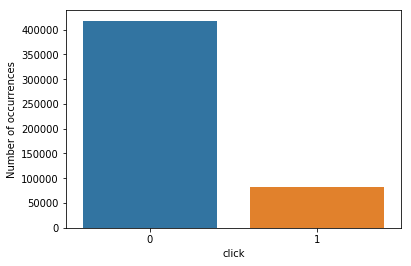

In [8]:
#可以看出由于数据经过下采样，数据正负比例并不大
sns.countplot(chunk.click)
plt.xlabel('click')
plt.ylabel('Number of occurrences')

# C1

Text(0,0.5,u'Number of occurrences')

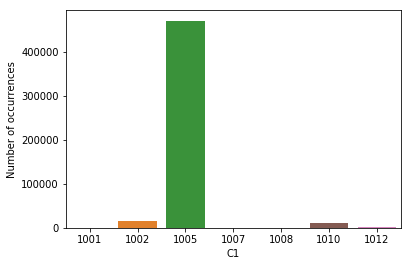

In [10]:
#C1的取值并不多，大量集中在1005
fig = plt.figure()
sns.countplot(chunk.C1)
plt.xlabel('C1')
plt.ylabel('Number of occurrences')

查看C1和click之间的关系

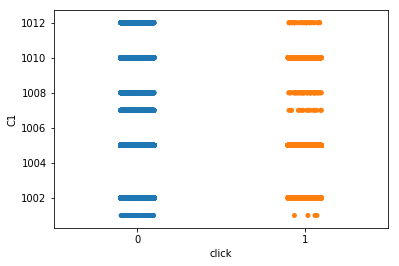

In [13]:
sns.stripplot(chunk.click,chunk.C1,jitter=True)

# banner_pos/广告位置

Text(0,0.5,u'Number of occurrences')

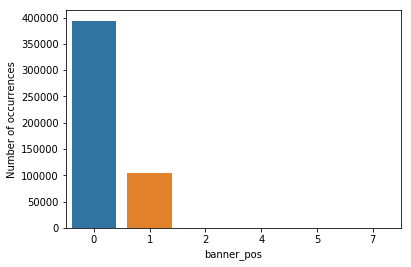

In [14]:
fig = plt.figure()
### Number of occurrences
sns.countplot(chunk.banner_pos)
plt.xlabel('banner_pos')
plt.ylabel('Number of occurrences')

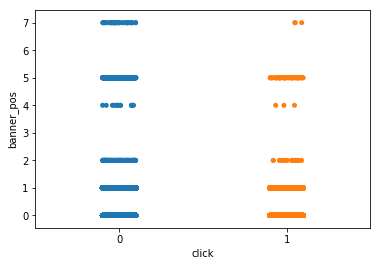

In [18]:
#clicked在banner_pos等于7和4的时候相当少
sns.stripplot(chunk.click,chunk.banner_pos,jitter=True)

# 为了方便先看C14-C21

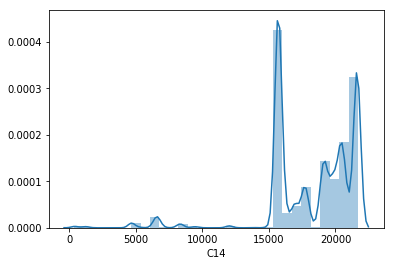

In [20]:
#这个分布太不高斯了，应该是多个分布混合了
sns.distplot(chunk.C14,bins=30,kde=True)
plt.xlabel('C14')
plt.show()

与click的关系

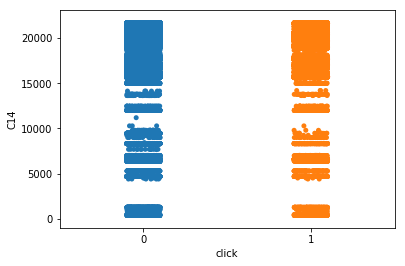

In [21]:
sns.stripplot(chunk.click,chunk.C14,jitter=True)

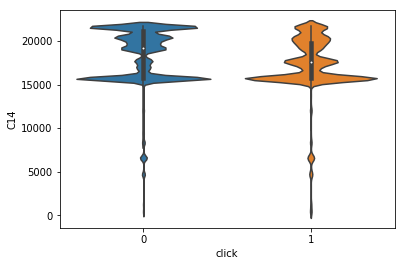

In [22]:
#再用violinpot看一眼会有什么发现
sns.violinplot(chunk.click,chunk.C14)
plt.xlabel('click')
plt.ylabel('C14')
plt.show()

# C15

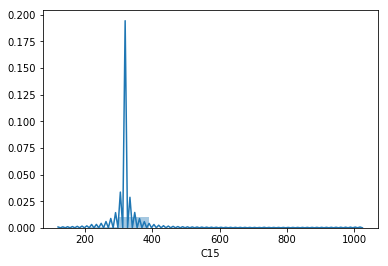

In [31]:
#这个分布很高斯，但是有过于拖尾的数据出现，但实际为类别型特征，所以不作为outliers
sns.distplot(chunk.C15,bins=10,kde=True)
plt.xlabel('C15')
plt.show()

In [30]:
chunk.C15.unique()

array([ 320,  300,  216,  728,  120, 1024,  480,  768], dtype=int64)

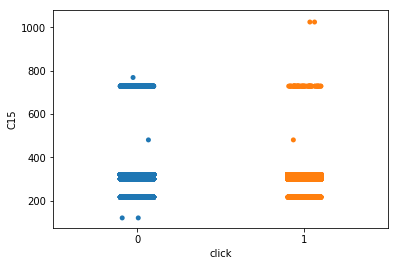

In [32]:
sns.stripplot(chunk.click,chunk.C15,jitter=True)

# C16

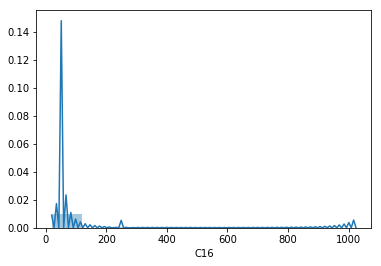

In [34]:
sns.distplot(chunk.C16,bins=10,kde=True)
plt.xlabel('C16')
plt.show()

In [33]:
chunk.C16.unique()

array([  50,  250,   36,  480,   90,   20,  768,  320, 1024], dtype=int64)

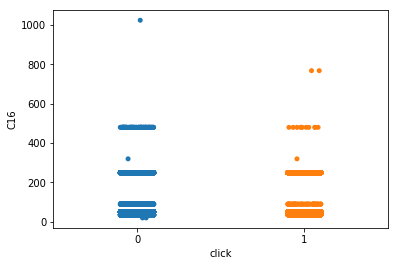

In [35]:
sns.stripplot(chunk.click,chunk.C16,jitter=True)

# C17

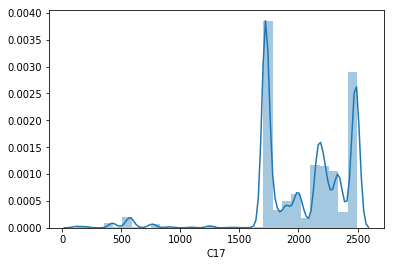

In [38]:
#C17的分布和C14很类似，以某种方式说，这两个特征有同样的表现能力
sns.distplot(chunk.C17,bins=30,kde=True)
plt.xlabel('C17')
plt.show()

In [36]:
chunk.C17.unique()

array([1722, 2161, 1899, 2333, 2374, 2496, 1974, 2227, 2371, 2043,  571,
       2434, 2493, 2480, 1882, 2158, 2271, 2446, 1800, 1934, 1863, 1887,
       1994,  423, 2495, 2153, 2253, 2264, 1996,  898, 1872, 2036, 2162,
        576, 2312, 1993, 2481,  572, 1973, 1921, 2331, 2449, 1740, 1926,
       1955, 2307, 1092,  901, 1637, 1784, 1895,  112, 2351,  122, 2323,
       2424, 2497, 2083, 2270, 2295, 1248, 1447, 2060,  196, 2306, 1780,
       2372,  547,  906, 2283, 2260, 1272, 2263, 1752, 2292, 1991, 2339,
       2039,  394, 2285, 2325, 2427, 1401, 2316, 1835, 2154,  937, 2286,
        613,  153, 2390, 2284, 2443, 2485,  544, 2467, 1528, 1769, 2303,
       2278,  549, 2465,  768, 2394, 2478,  686, 2471, 2304, 1698, 2279,
       1932,  178, 2346, 1685, 2483, 2476, 1255, 2225, 2438, 2425, 1884,
        827, 2459, 2397, 1507, 2250, 2482,  550, 2201, 2487, 2229, 2348,
       2492,  761, 2418, 2242, 2421,  479, 1873, 2420, 2281, 2206, 1515,
       2101, 1253, 2218, 1149, 2187, 1008, 2282, 19

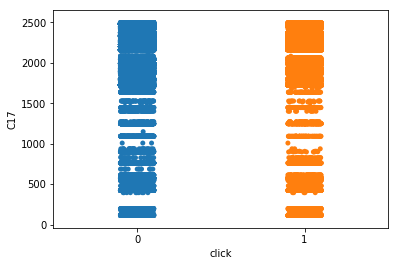

In [39]:
sns.stripplot(chunk.click,chunk.C17,jitter=True)

# C18

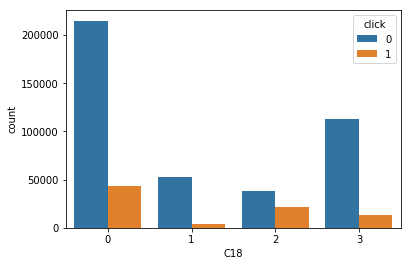

In [41]:
#C18
sns.countplot(chunk.C18,hue=chunk.click)
plt.xlabel('C18')
plt.show()

In [40]:
chunk.C18.unique()

array([0, 3, 2, 1], dtype=int64)

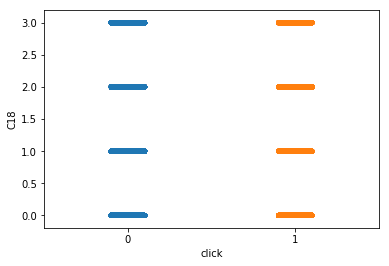

In [42]:
sns.stripplot(chunk.click,chunk.C18,jitter=True)

# C19

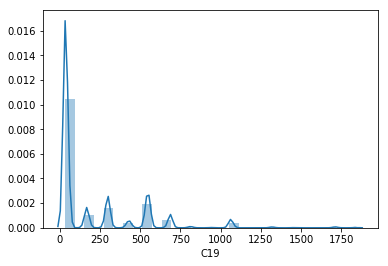

In [45]:
#C19看上去像是多个高斯混合
sns.distplot(chunk.C19,bins=30,kde=True)
plt.xlabel('C19')
plt.show()

In [44]:
chunk.C19.unique()

array([  35,  431,   39,  167,  687,  551,  163,  297,  291,  171,  427,
        303,   41,   47, 1063,  943, 1835, 1315,  161,  175,  681, 1319,
         43,  169,  683, 1711,  813, 1451,  559,  423,  801,  673, 1327,
         33,  679, 1071,  425,  547,   45,  299], dtype=int64)

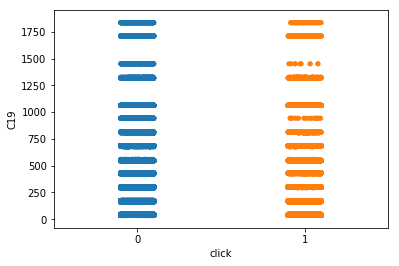

In [46]:
sns.stripplot(chunk.click,chunk.C19,jitter=True)

# C20

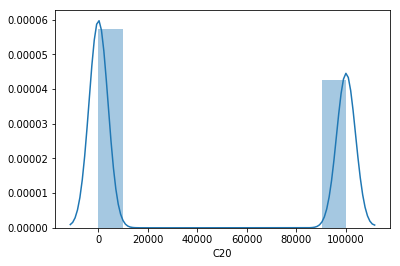

In [51]:
sns.distplot(chunk.C20,bins=10,kde=True)
plt.xlabel('C20')
plt.show()

In [43]:
chunk.C20.unique()

array([    -1, 100084, 100077, 100191, 100019, 100148, 100088, 100083,
       100217, 100111, 100193, 100034, 100075, 100228, 100131, 100188,
       100202, 100021, 100200, 100050, 100063, 100000, 100081, 100057,
       100003, 100130, 100076, 100079, 100233, 100128, 100106, 100060,
       100002, 100074, 100020, 100156, 100046, 100005, 100105, 100013,
       100028, 100215, 100119, 100173, 100210, 100221, 100161, 100189,
       100048, 100151, 100190, 100049, 100062, 100194, 100241, 100248,
       100224, 100026, 100103, 100205, 100160, 100212, 100041, 100070,
       100138, 100185, 100225, 100065, 100037, 100029, 100199, 100101,
       100094, 100162, 100171, 100192, 100095, 100052, 100087, 100086,
       100126, 100097, 100072, 100117, 100170, 100012, 100107, 100166,
       100183, 100025, 100163, 100206, 100155, 100176, 100068, 100039,
       100168, 100055, 100112, 100096, 100022, 100054, 100150, 100122,
       100149, 100001, 100177, 100141, 100213, 100043, 100010, 100139,
      

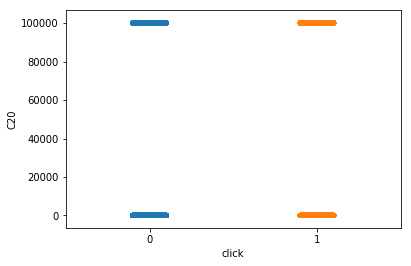

In [52]:
sns.stripplot(chunk.click,chunk.C20,jitter=True)

# C21

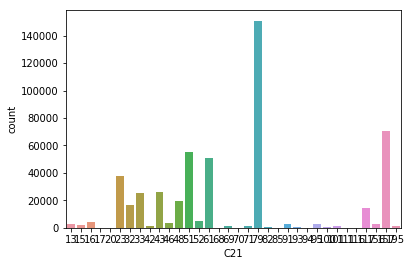

In [54]:
sns.countplot(chunk.C21)
plt.xlabel('C21')
plt.show()

In [53]:
chunk.C21.unique()

array([ 79, 157, 117,  23,  33,  48,  46,  32,  61,  13, 156,  16,  52,
        71,  91, 100,  95, 101,  15,  42, 111,  82,  70,  94,  20,  68,
        93, 116,  85,  43,  51, 195,  69,  17], dtype=int64)

匿名类别分析：单从数据分布来看，C14 C17 C21拥有更大的信息量，因为这三个分布都比其他数据分布更趋于均匀分布（熵大），所以在理论上来说这三者较为重要

# site 三兄弟

site id

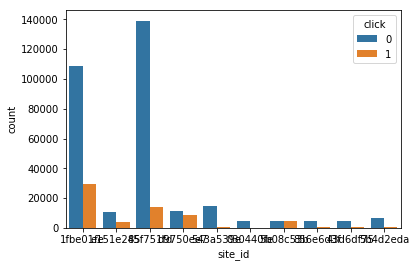

In [68]:
#hash化的siteid值太多了，考虑将出现次数少于某一阈值定义为other
#数据探索阶段我们看频率最高的前10个
top10 = chunk.site_id.value_counts().nlargest(10).index.tolist()
fig =plt.figure()
sns.countplot(x="site_id",hue="click",data=chunk[chunk.site_id.isin(top10)])

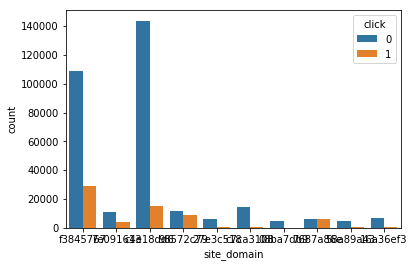

In [69]:
top10 = chunk.site_domain.value_counts().nlargest(10).index.tolist()
fig =plt.figure()
sns.countplot(x="site_domain",hue="click",data=chunk[chunk.site_domain.isin(top10)])

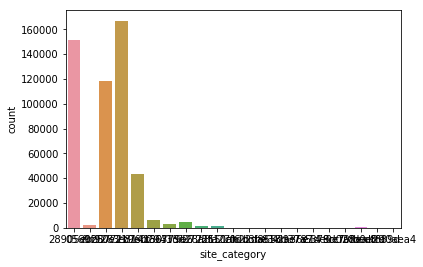

In [70]:
sns.countplot(chunk.site_category)

# app三兄弟

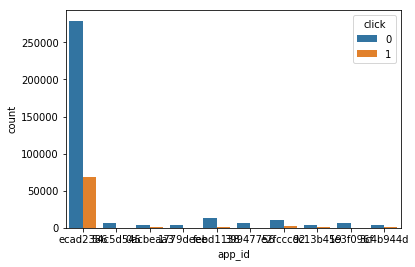

In [71]:
top10 = chunk.app_id.value_counts().nlargest(10).index.tolist()
fig =plt.figure()
sns.countplot(x="app_id",hue="click",data=chunk[chunk.app_id.isin(top10)])

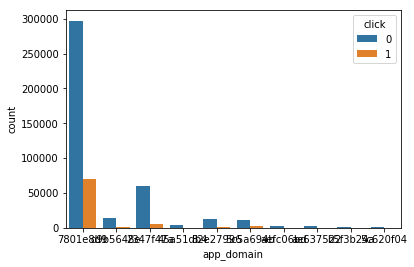

In [72]:
top10 = chunk.app_domain.value_counts().nlargest(10).index.tolist()
fig =plt.figure()
sns.countplot(x="app_domain",hue="click",data=chunk[chunk.app_domain.isin(top10)])

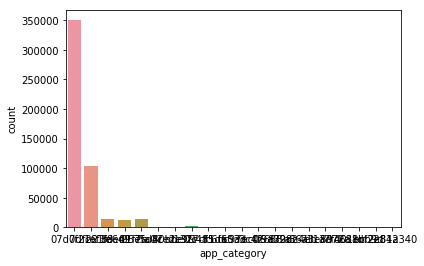

In [73]:
sns.countplot(chunk.app_category)

分析：从数据分布的角度，app和site含有的信息量并不大，都是一多其他少的情况。
从实际背景的角度，app和site的特征附属于刻画用户，这里考虑和deviice联合一下，生成更具特征表达能力的特征

# device几兄弟

id

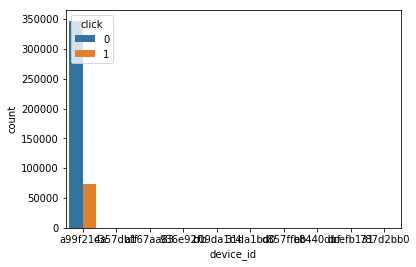

In [74]:
#hash化的id,这里id有点过于单一化了
top10 = chunk.device_id.value_counts().nlargest(10).index.tolist()
fig =plt.figure()
sns.countplot(x="device_id",hue="click",data=chunk[chunk.device_id.isin(top10)])

ip 

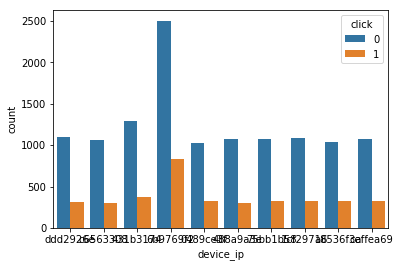

In [75]:
#实际背景出发判断，ip是相当于标识了某个用户
top10 = chunk.device_ip.value_counts().nlargest(10).index.tolist()
fig =plt.figure()
sns.countplot(x="device_ip",hue="click",data=chunk[chunk.device_ip.isin(top10)])

model

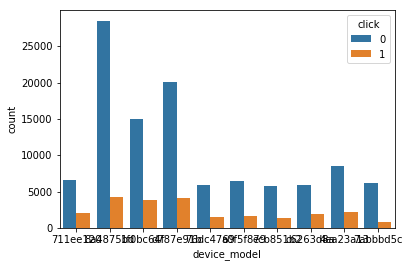

In [76]:
top10 = chunk.device_model.value_counts().nlargest(10).index.tolist()
fig =plt.figure()
sns.countplot(x="device_model",hue="click",data=chunk[chunk.device_model.isin(top10)])

type

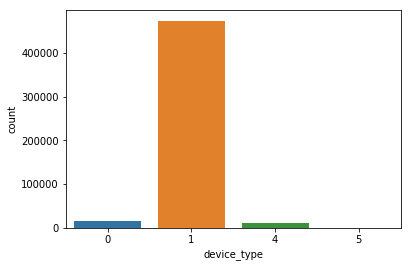

In [78]:
sns.countplot(chunk.device_type)

conn type

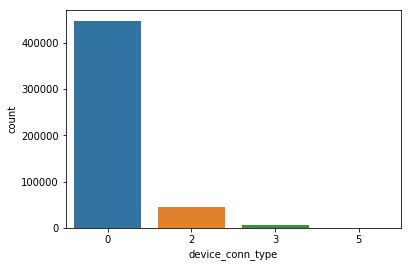

In [79]:
sns.countplot(chunk.device_conn_type)

总结分析：匿名特征中，大概看出C14，C17，C21的信息量比较大，应该属于比较重要的特征
device和site还有app兄弟们之间，数据过于单一，考虑在特征工程中生成新的特征达到更有效特征表示能力。

# 最后看一下10天的点击率分布情况

用滑动平均来观察变化，decay=0.999

In [81]:
ites_1 = pd.read_csv('train/train.csv',iterator=True)
decay = 0.999
hour_n = np.array([0],dtype=np.float16)
for i in xrange(4000):
    chunk_hour =ites_1.get_chunk(10000)
    #num_0 = chunk_hour[chunk_hour['click']==0]['click'].count()
    num_1 = chunk_hour[chunk_hour['click']==1]['click'].count()
    hour_n = np.append(hour_n,num_1/10000.0)

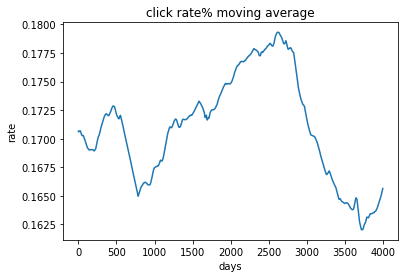

In [82]:
#去除第一个数0
hour_n = hour_n[1:]
plt.title('click rate% moving average')
moving_hour_n = np.array([hour_n[0]],dtype=np.float16)
shadow_variable  =hour_n[0]
for i in xrange(1,4000):
    shadow_variable = shadow_variable*decay + hour_n[i]*(1-decay)
    moving_hour_n = np.append(moving_hour_n,shadow_variable)
plt.plot(range(4000),moving_hour_n)
plt.xlabel("days")
plt.ylabel("rate")
plt.show()